# Taller 4. Mapeo de QTL por ligamiento
Genética de rasgos complejos 2024-01 - Universidad Nacional de Colombia<br>
Docente Johana Carolina Soto Sedano - jcsotos@unal.edu.co  
 
 
__Hans D. Escobar H.__

In [1]:
# Environment setup

# libraries validation
if (!require("qtl", quietly = TRUE)) {
  stop("Error: missing Rqtl package")
}

# paths validation
data_file_path <- "../Private_Data/data.csv"
if (!file.exists(data_file_path)) {
  stop("Error: file doesn't exist, check the path.")
}


## 1. Explore data

La estructura esperada para importar mapas desde CSV puede ser consultada con:

```R
help(read.cross)
```

Explorando la tabla estructura de la tabla:

In [2]:
read.table(data_file_path, header = TRUE, nrows = 5, sep = ",")


Pheno,Mark1,Mark2,Mark3,Mark4,Mark5,Mark6,Mark7,Mark8,Mark9,⋯,Mark991,Mark992,Mark993,Mark994,Mark995,Mark996,Mark997,Mark998,Mark999,Mark1000
<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
NA,1,1,1,1,1,1,1,1,1,⋯,10,10,10,10,10,10,10,10,10,10
NA,1,2,3,4,5,6,7,8,9,⋯,91,92,93,94,95,96,97,98,99,100
41.04670,0,0,0,1,1,1,0,1,0,⋯,0,0,0,1,0,0,0,1,0,0
-7.06822,1,0,1,1,1,1,1,0,1,⋯,0,1,1,1,0,0,0,1,1,0
32.00474,1,1,0,1,1,1,1,1,1,⋯,0,1,1,0,1,0,0,1,0,1


Es importante que los marcadores usen los mismos códigos para genotipos. Recordemos que en caso de un cruce _backcross_ se tiene dos genotipos, por lo que requiere dos códigos. En el caso de un _intercross_ y en condiciones que se puede diferenciar homocigotos de diferentes alelos, se requieren 3, en caso contrario 5.

Miremos cuantos códigos de genotipo hay en la tabla:

In [3]:
raw_table <- read.table(data_file_path, header = TRUE, sep = ",")
cat("Genotype codes:", unique(as.numeric(raw_table[3, 2:ncol(raw_table)])))


Genotype codes: 0 1

Miremos cuantos datos perdidos hay:

In [4]:
cat("Number of missing values:", sum(is.na(raw_table[3, ])))


Number of missing values: 0

Conociendo esta información podemos cargar nuestros datos para Rqtl:

In [5]:
raw_data <- read.cross(
  format = "csv", file = data_file_path,
  na.strings = "NA", genotype = c("0", "1")
)


 --Read the following data:
	 500  individuals
	 1000  markers
	 1  phenotypes
 --Cross type: bc 


1. En tipo de cruce dice: bc (backcross). ¿Cuál será la relación genotípica? ¿Con SNPs 
como serían los genotipos de los padres?

- La relación es 1:1. $A_1/A_1 : A_1/A_2\space \text{s.t. } A_1 \neq A_2;\space A_1, A_2 \in \{A,G,C,T\}$
- Homocigotos para nucleótidos diferentes. $A_1/A_1,\space A_2/A_2,\space \text{s.t. } A_1 \neq A_2;\space A_1, A_2 \in \{A,G,C,T\}$

In [6]:
summary(raw_data)


    Backcross

    No. individuals:    500 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    10 
        Autosomes:      1 2 3 4 5 6 7 8 9 10 

    Total markers:      1000 
    No. markers:        100 100 100 100 100 100 100 100 100 100 
    Percent genotyped:  100 
    Genotypes (%):      AA:50.0  AB:50.0 

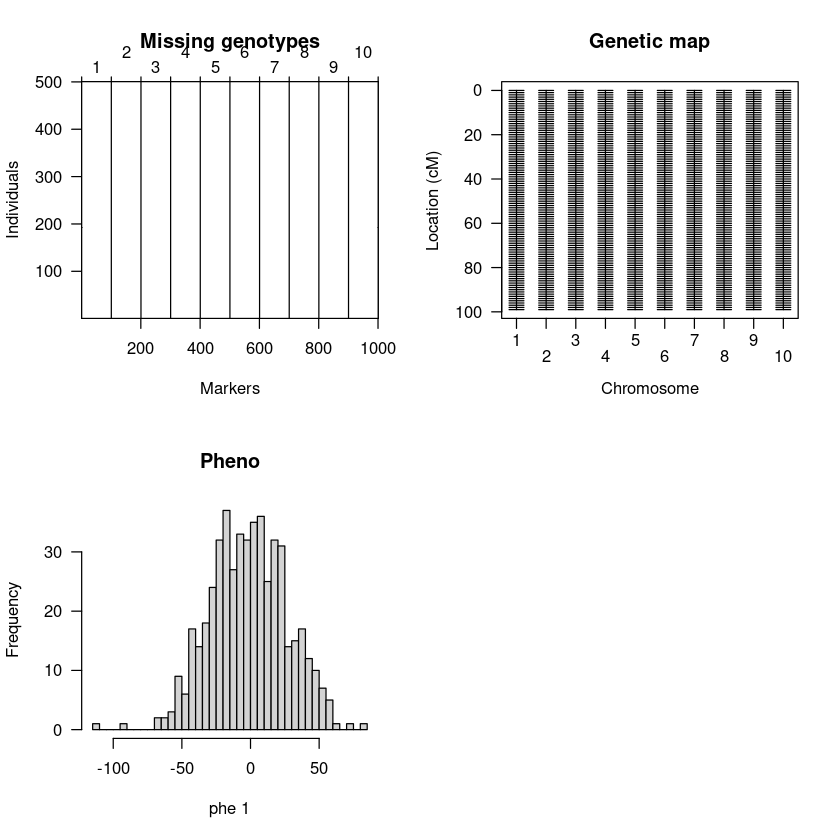

In [7]:
plot(raw_data) # plot.missing plot.map plot.pheno


In [17]:
cat("Markers by chromosome:\n")
print(nmar(raw_data))


Markers by chromosome:
  1   2   3   4   5   6   7   8   9  10 
100 100 100 100 100 100 100 100 100 100 


2. ¿Observando las gráficas que puede deducir de los datos? 